[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading and merging datasets...
Merged dataset shape: (184354, 2)

Balancing classes...
Balanced dataset shape: (71828, 2)

Cleaning text...
Found 400000 word vectors.


c:\Users\Angelika Vergara\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
c:\Users\Angelika Vergara\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\Angelika Vergara\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Epoch 1: 100%|██████████| 2021/2021 [1:04:40<00:00,  1.92s/it]


Epoch 1 | Train Loss: 0.1648 | Val Loss: 0.1342 | Train Acc: 0.9333 | Val Acc: 0.9435


Training Epoch 2: 100%|██████████| 2021/2021 [1:04:44<00:00,  1.92s/it]


Epoch 2 | Train Loss: 0.0987 | Val Loss: 0.1191 | Train Acc: 0.9627 | Val Acc: 0.9524


Training Epoch 3: 100%|██████████| 2021/2021 [1:07:49<00:00,  2.01s/it]


Epoch 3 | Train Loss: 0.0572 | Val Loss: 0.1475 | Train Acc: 0.9793 | Val Acc: 0.9517


Training Epoch 4: 100%|██████████| 2021/2021 [1:08:24<00:00,  2.03s/it]


Epoch 4 | Train Loss: 0.0309 | Val Loss: 0.2045 | Train Acc: 0.9899 | Val Acc: 0.9521


Training Epoch 5: 100%|██████████| 2021/2021 [1:08:57<00:00,  2.05s/it]


Epoch 5 | Train Loss: 0.0202 | Val Loss: 0.2067 | Train Acc: 0.9936 | Val Acc: 0.9492
Early stopping triggered.


C:\Users\Angelika Vergara\AppData\Local\Temp\ipykernel_19108\1448122038.py:371: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_hybrid_m

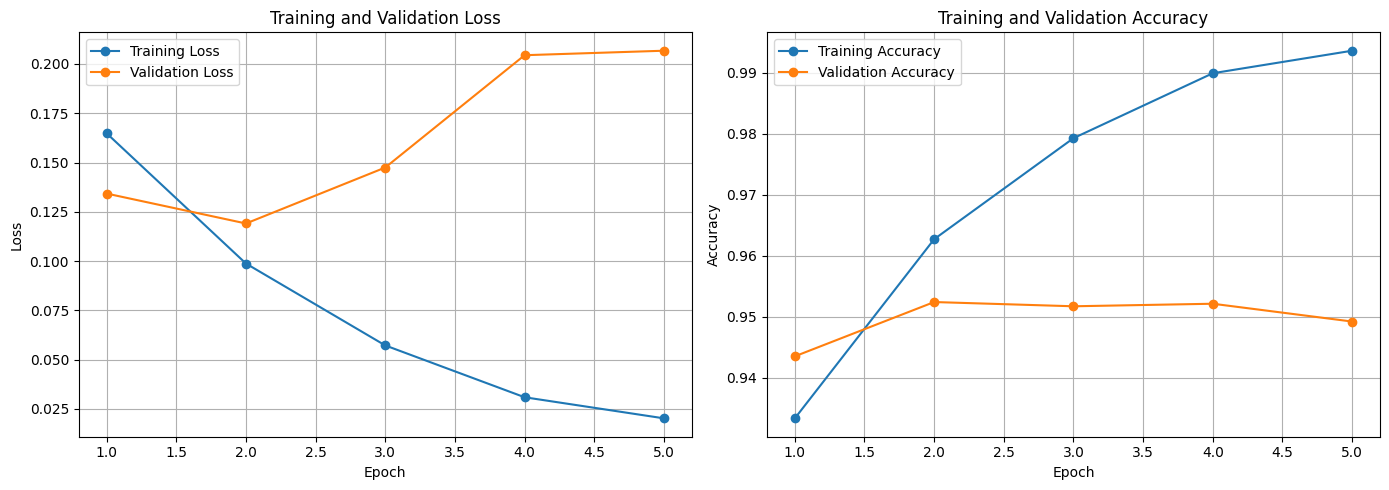

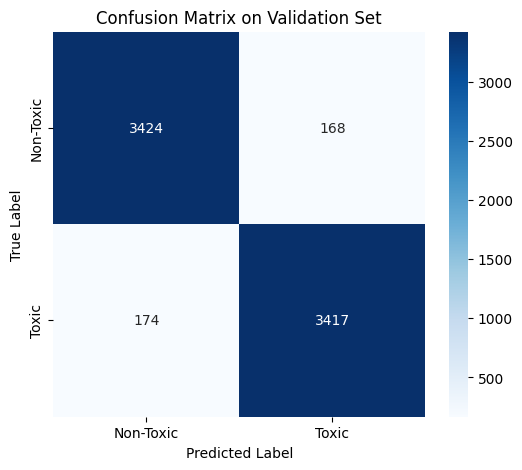

{'non_toxic_prob': 0.008124063, 'toxic_prob': 0.9918759}
{'non_toxic_prob': 0.99514717, 'toxic_prob': 0.004852819}


In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from textblob import TextBlob
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# 1. Prepare Labels function
def prepare_labels(df):
    text_col = None
    for possible_col in ["comment_text", "text"]:
        if possible_col in df.columns:
            text_col = possible_col
            break
    if text_col is None:
        raise ValueError(f"No recognized text column found. Columns: {df.columns.tolist()}")
    
    if "toxic" in df.columns:
        df["class"] = np.where(df["toxic"] >= 0.5, 1, 0)
    else:
        raise ValueError(f"No 'toxic' column found for labels. Columns: {df.columns.tolist()}")
    
    return df[[text_col, "class"]].rename(columns={text_col: "tweet"})

# 2. Load and merge datasets
print("Loading and merging datasets...")

df1 = pd.read_csv("./data/labeled_data.csv")  # Davidson et al.
df1 = df1.rename(columns={"tweet": "tweet", "class": "label"})
df1["class"] = df1["label"].apply(lambda x: 1 if x in [0, 1] else 0)
df1 = df1[["tweet", "class"]]

df2 = pd.read_csv("./data/train.csv")  # Jigsaw dataset
df2_prepared = prepare_labels(df2)

combined_df = pd.concat([df1, df2_prepared], ignore_index=True)
combined_df.drop_duplicates(subset="tweet", inplace=True)

print("Merged dataset shape:", combined_df.shape)
prepared_df = combined_df

# 3. Balance dataset
print("\nBalancing classes...")
df_majority = prepared_df[prepared_df["class"] == 0]
df_minority = prepared_df[prepared_df["class"] == 1]
if len(df_minority) == 0:
    raise ValueError("No toxic samples found in dataset!")

df_majority_downsampled = resample(df_majority, n_samples=len(df_minority), random_state=42)
balanced_df = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced dataset shape:", balanced_df.shape)

# 4. Text cleaning utils
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+|\#", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return " ".join(tokens)

print("\nCleaning text...")
balanced_df['cleaned_text'] = balanced_df['tweet'].apply(clean_text)

# 5. Subjectivity and identity term features
IDENTITY_TERMS = [
    "muslim", "jew", "black", "white", "asian", "latino", "women", "men", "gay", "lesbian",
    "trans", "christian", "atheist", "immigrant", "indian", "arab", "african", "hispanic"
]

def compute_subjectivity(text):
    return float(TextBlob(text).sentiment.subjectivity)

def has_identity_term(text):
    text_lower = text.lower()
    return int(any(term in text_lower for term in IDENTITY_TERMS))

balanced_df['subjectivity'] = balanced_df['tweet'].apply(compute_subjectivity)
balanced_df['identity_flag'] = balanced_df['tweet'].apply(has_identity_term)

# 6. Tokenizer setup
MAX_LEN = 128
VOCAB_SIZE = 30000  # Consistent with your embedding layer

# LSTM tokenizer (Keras style)
lstm_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
lstm_tokenizer.fit_on_texts(balanced_df['cleaned_text'].tolist())
word_index = lstm_tokenizer.word_index

def lstm_tokenize(texts):
    seqs = lstm_tokenizer.texts_to_sequences(texts)
    return pad_sequences(seqs, maxlen=MAX_LEN, padding='post', truncating='post')

# BERT tokenizer (Huggingface)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 7. Embedding matrix (use GloVe or similar)
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Load GloVe embeddings or similar (replace with your method)
embeddings_index = {}
with open('./glove.6B/glove.6B.300d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

# Fill embedding matrix
num_words = min(VOCAB_SIZE, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# 8. Dataset class
class HybridDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        lstm_seq = lstm_tokenize([row['cleaned_text']])[0]
        lstm_seq = torch.tensor(lstm_seq, dtype=torch.long)
        
        bert_enc = bert_tokenizer.encode_plus(
            row['cleaned_text'],
            add_special_tokens=True,
            max_length=MAX_LEN,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = bert_enc['input_ids'].squeeze(0)
        attention_mask = bert_enc['attention_mask'].squeeze(0)
        
        subjectivity = torch.tensor([row['subjectivity']], dtype=torch.float)
        identity_flag = torch.tensor([row['identity_flag']], dtype=torch.float)
        label = torch.tensor(row['class'], dtype=torch.long)
        
        return {
            'lstm_seq': lstm_seq,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'subjectivity': subjectivity,
            'identity_flag': identity_flag,
            'label': label
        }

# 9. Train/validation split and loaders
train_df, val_df = train_test_split(balanced_df, test_size=0.1, random_state=42, stratify=balanced_df['class'])

train_dataset = HybridDataset(train_df)
val_dataset = HybridDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# 10. Hybrid Model Definition (using Keras LSTM structure)
class HybridLSTM_BERT(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, embed_dim=300, lstm_hidden=256, bert_model_name='bert-base-uncased', num_classes=2, dropout=0.3, recurrent_dropout=0.3, l2_reg=0.01):
        super().__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True  # Fine-tune embeddings

        # LSTM layer (implement dropout manually for recurrent connections)
        self.lstm = nn.LSTM(embed_dim, lstm_hidden, batch_first=True, dropout=dropout)

        # BERT model
        self.bert = BertModel.from_pretrained(bert_model_name)
        
        # Classifier
        combined_dim = lstm_hidden + self.bert.config.hidden_size + 2
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(combined_dim, num_classes)

    def forward(self, lstm_seq, input_ids, attention_mask, subjectivity, identity_flag):
        # LSTM branch
        emb = self.embedding(lstm_seq)  # (batch, seq_len, embed_dim)
        lstm_out, _ = self.lstm(emb)   # (batch, seq_len, lstm_hidden)

        lstm_out = lstm_out[:, -1, :]  # Use the last output

        # BERT branch
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output

        # Concatenate
        combined = torch.cat([lstm_out, bert_out, subjectivity, identity_flag], dim=1)

        # Classifier
        x = self.dropout(combined)
        logits = self.classifier(x)
        return logits

# 11. Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridLSTM_BERT(
    vocab_size=num_words,
    embedding_matrix=embedding_matrix
).to(device)  # Pass num_words

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01) # Keep some L2
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, verbose=True) # Learning rate decay

epochs = 50
total_steps = len(train_loader) * epochs

best_val_loss = float('inf')
patience = 3
patience_counter = 0

# 12. Training Loop with tracking for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()
        lstm_seq = batch['lstm_seq'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        subjectivity = batch['subjectivity'].to(device)
        identity_flag = batch['identity_flag'].to(device)
        labels = batch['label'].to(device)
        
        logits = model(lstm_seq, input_ids, attention_mask, subjectivity, identity_flag)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = correct_train / total_train

    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            lstm_seq = batch['lstm_seq'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            subjectivity = batch['subjectivity'].to(device)
            identity_flag = batch['identity_flag'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(lstm_seq, input_ids, attention_mask, subjectivity, identity_flag)
            loss = criterion(logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct_val / total_val

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    scheduler.step(avg_val_loss) # Learning rate decay

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_hybrid_model.pt')
        patience_counter = 0
        best_preds = all_preds
        best_labels = all_labels
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# 13. Plotting function
def plot_training_history_and_confusion_matrix(train_losses, val_losses, train_acc, val_acc, true_labels, pred_labels):
    epochs_range = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(14, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix on Validation Set')
    plt.show()

# 14. Load Best Model & Prediction function
model.load_state_dict(torch.load('best_hybrid_model.pt'))
model.eval()

def predict(text):
    cleaned = clean_text(text)
    lstm_seq = lstm_tokenize([cleaned])
    lstm_seq = torch.tensor(lstm_seq, dtype=torch.long).to(device)
    
    bert_enc = bert_tokenizer.encode_plus(
        cleaned,
        add_special_tokens=True,
        max_length=MAX_LEN,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = bert_enc['input_ids'].to(device)
    attention_mask = bert_enc['attention_mask'].to(device)
    
    subjectivity = torch.tensor([[compute_subjectivity(text)]], dtype=torch.float).to(device)
    identity_flag = torch.tensor([[has_identity_term(text)]], dtype=torch.float).to(device)
    
    with torch.no_grad():
        logits = model(lstm_seq, input_ids, attention_mask, subjectivity, identity_flag)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    return {'non_toxic_prob': probs[0], 'toxic_prob': probs[1]}

# 15. Plot training history and confusion matrix
plot_training_history_and_confusion_matrix(train_losses, val_losses, train_accuracies, val_accuracies, best_labels, best_preds)

# 16. Example predictions
print(predict("You are an idiot!"))
print(predict("I love everyone regardless of their background."))


In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming best_labels and best_preds are your true and predicted labels on the validation set
accuracy = accuracy_score(best_labels, best_preds)
precision = precision_score(best_labels, best_preds)
recall = recall_score(best_labels, best_preds)
f1 = f1_score(best_labels, best_preds)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


Accuracy : 0.9524
Precision: 0.9531
Recall   : 0.9515
F1 Score : 0.9523
